In [ ]:
import torch
import sys

sys.path.append("../")

from samples.models import get_model, MODEL_REGISTRY

# Check available models
print(f"Available models: {list(MODEL_REGISTRY.keys())}")

# Load AFib classification model (automatically downloads if download=True and file not found)
model = get_model(
    name="afib_binary",
    model_dir="../tmp/models/afib_binary/",
    download=True,
)
print(f"Model loaded: {model.__class__.__name__}")

In [49]:
# Wrap model with TorchModelWrapper
from execg.models.wrapper import TorchModelWrapper

wrapped_model = TorchModelWrapper(model)
print(f"Wrapped model: {wrapped_model}")
print(f"Device: {wrapped_model.device}")

Wrapped model: TorchModelWrapper(model=ResNetDropoutAfib, device=cpu)
Device: cpu


In [ ]:
# Generator configuration
generator_dir = "../tmp/models/stylegan/"
device = "cuda:3"

# Check available generator models
from execg.counterfactual.models import MODEL_REGISTRY as GENERATOR_REGISTRY

print(f"Available generators: {list(GENERATOR_REGISTRY.keys())}")

In [51]:
# Load or generate sample ECG data
import json
import numpy as np

with open("../samples/data/sample.json", "r") as f:
    sample_data = json.load(f)
ecg_signal = np.array(
    list(sample_data["data"].values())
)  # shape: (n_leads, seq_length)
print(f"Loaded sample ECG data: shape = {ecg_signal.shape}")

# Convert to Tensor - transform to (1, n_leads, seq_length) shape
ecg_tensor = (
    torch.tensor(ecg_signal, dtype=torch.float32)[:, ::2].unsqueeze(0).to(device)
)
print(f"ECG tensor shape: {ecg_tensor.shape}  # (batch=1, leads, length)")

Loaded sample ECG data: shape = (12, 5000)
ECG tensor shape: torch.Size([1, 12, 2500])  # (batch=1, leads, length)


## StyleGAN-based Counterfactual Explanation

Counterfactual explanation answers the question: "How should we change the input to alter the model's prediction?"

StyleGANCF generates counterfactuals in the following steps:
1. **W-space Inversion**: Map input ECG to StyleGAN's latent space
2. **Counterfactual Generation**: Adjust the latent vector to achieve the desired prediction

### Input Requirements
- **Duration**: Exactly 10 seconds (number of samples depends on sampling_rate)
- **Sampling Rate**: Automatic resampling supported (nearest interpolation)
  - Generator operates internally at 250Hz
  - Output is restored to original sampling rate

In [52]:
# Check model prediction for original ECG
with torch.no_grad():
    original_pred = wrapped_model.predict(ecg_tensor)

print(f"Original prediction shape: {original_pred.shape}")
print(f"Original prediction: {original_pred.cpu().numpy()}")
print(f"Predicted class: {original_pred.argmax().item()}")

Original prediction shape: torch.Size([1, 2])
Original prediction: [[9.9952483e-01 4.7515583e-04]]
Predicted class: 0


In [53]:
from execg.counterfactual import StyleGANCF

# Create StyleGANCF instance
# generator_name: Generator model name (registered in MODEL_REGISTRY)
# model_dir: Directory to store/load model files (code and weights)
# sampling_rate: Sampling rate of input ECG data (Hz)
#   - Generator operates internally at 250Hz
#   - Data with different sampling rates is automatically resampled
# download: If True, automatically downloads code and weights from Google Drive when not found
cf_explainer = StyleGANCF(
    model=wrapped_model.to(device),
    generator_name="stylegan250",
    model_dir=generator_dir,
    sampling_rate=250,  # Input data sampling rate (500Hz data downsampled by 2x = 250Hz)
    download=True,  # Auto-download if file missing
)
print("StyleGANCF initialized")
print(f"Input sampling rate: {cf_explainer.sampling_rate} Hz")
print(f"Generator sampling rate: {cf_explainer.GENERATOR_SAMPLING_RATE} Hz")

StyleGANCF initialized
Input sampling rate: 250 Hz
Generator sampling rate: 250 Hz


## 1. Basic Counterfactual Generation

Generate counterfactual ECG that increases or decreases the probability of a specific class.

In [ ]:
# Generate Counterfactual
# target: Output index (class) to change
# target_value: Target probability value (0.0 ~ 1.0)

target = 1  # target class
target_value = 1.0  # Change to classify as this class

cf_ecg, cf_prob, etc = cf_explainer.explain(
    ecg_tensor,
    target=target,
    target_value=target_value,
    inversion_steps=1000,  # W-inversion optimization steps
    inversion_lr=0.001,  # W-inversion learning rate
    cf_steps=800,  # CF generation optimization steps
    cf_lr=0.001,  # CF learning rate
    verbose=True,  # Print progress
    show_plot=True,  # Show plot during optimization
)

print(f"\nCounterfactual ECG shape: {cf_ecg.shape}")
print(f"Counterfactual probability: {cf_prob:.4f}")

## 2. Counterfactual Visualization

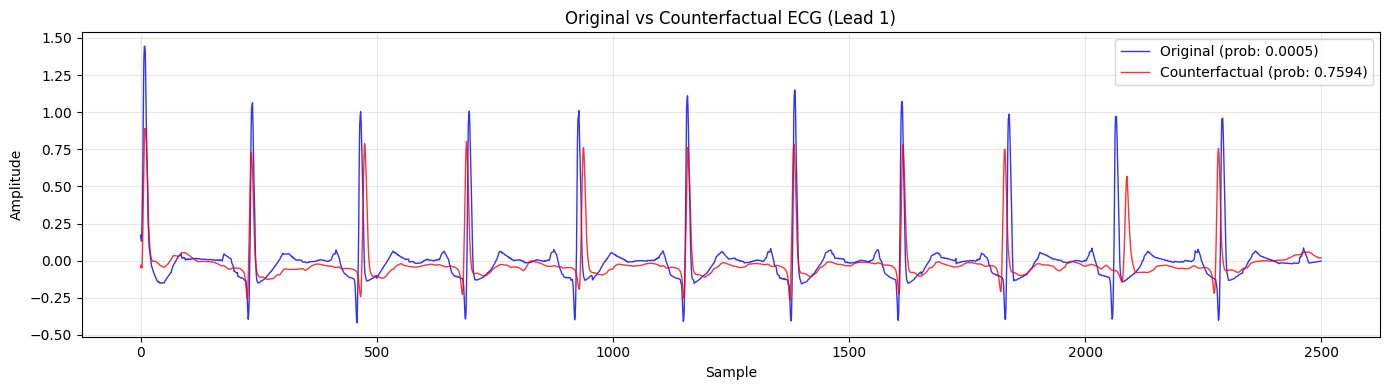

In [57]:
# Import visualization module and visualize
from execg.visualizer import plot_counterfactual_overlay

# Convert original ECG to numpy
original_ecg_np = ecg_tensor.squeeze(0).cpu().numpy()

# Overlay original and counterfactual
plot_counterfactual_overlay(
    original_ecg_np,
    cf_ecg,
    lead_idx=1,
    original_prob=original_pred[0][1].item(),
    cf_prob=cf_prob,
)

## 3. Counterfactual Generation Process Visualization

The `etc` dictionary stores all counterfactuals and probabilities generated during optimization.

In [ ]:
# Visualize probability change
from execg.visualizer import plot_counterfactual_progress

all_probs = etc["all_probs"]
plot_counterfactual_progress(all_probs, target_value, target)

In [ ]:
# Visualize CF generation process ECG
from execg.visualizer import plot_counterfactual_evolution

all_cf = etc["all_cf"]
plot_counterfactual_evolution(all_cf, all_probs, lead_idx=1, n_steps=5)

## 4. Counterfactual Using Specific Layers

Use the `layer_use` parameter to optimize only specific layers of StyleGAN:
- **Lower layer numbers**: Related to R-R interval (rhythm)
- **Higher layer numbers**: Related to QRS complex (morphology)

In [ ]:
# Use only low layers (rhythm-related changes)
cf_rhythm, cf_prob_rhythm, _ = cf_explainer.explain(
    ecg_tensor,
    target=target,
    target_value=target_value,
    layer_use=[0, 1, 2],  # Use only low layers
    inversion_steps=500,
    cf_steps=300,
    verbose=True,
)

print(f"Rhythm-focused CF probability: {cf_prob_rhythm:.4f}")

In [ ]:
# Use only high layers (morphology-related changes)
cf_morphology, cf_prob_morph, _ = cf_explainer.explain(
    ecg_tensor,
    target=target,
    target_value=target_value,
    layer_use=[5, 6, 7],  # Use only high layers
    inversion_steps=500,
    cf_steps=300,
    verbose=True,
)

print(f"Morphology-focused CF probability: {cf_prob_morph:.4f}")

In [ ]:
# Compare CFs by layer
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
lead_idx = 1

axes[0].plot(original_ecg_np[lead_idx], "b-", linewidth=0.8, label="Original")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original ECG")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(
    original_ecg_np[lead_idx], "b-", linewidth=0.8, alpha=0.5, label="Original"
)
axes[1].plot(
    cf_rhythm[lead_idx],
    "r-",
    linewidth=0.8,
    label=f"Rhythm CF (prob: {cf_prob_rhythm:.4f})",
)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Low Layer CF (Rhythm-focused)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(
    original_ecg_np[lead_idx], "b-", linewidth=0.8, alpha=0.5, label="Original"
)
axes[2].plot(
    cf_morphology[lead_idx],
    "g-",
    linewidth=0.8,
    label=f"Morphology CF (prob: {cf_prob_morph:.4f})",
)
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Sample")
axes[2].set_title("High Layer CF (Morphology-focused)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Reverse Direction Counterfactual

You can also generate counterfactuals that decrease the current prediction.

In [ ]:
# Counterfactual to decrease probability
predicted_class = original_pred.argmax().item()

cf_negative, cf_prob_neg, _ = cf_explainer.explain(
    ecg_tensor,
    target=predicted_class,
    target_value=0.0,  # Decrease probability to 0
    inversion_steps=500,
    cf_steps=300,
    verbose=True,
)

print(
    f"\nOriginal class {predicted_class} probability: {original_pred[0][predicted_class]:.4f}"
)
print(f"Negative CF class {predicted_class} probability: {cf_prob_neg:.4f}")

## 6. All Leads Visualization

In [ ]:
# 12-lead comparison visualization
from execg.visualizer import plot_counterfactual_all_leads

plot_counterfactual_all_leads(
    original_ecg_np,
    cf_ecg,
    original_prob=original_pred[target].item(),
    cf_prob=cf_prob,
    target=target,
)

## 7. Counterfactual with Attribution Visualization

Combine counterfactual explanation with attribution map to understand:
- **Attribution**: Which regions of the original ECG are important for the model's prediction
- **Counterfactual**: How the ECG should change to alter the prediction

In [99]:
# Compute attribution for original ECG
from execg.attribution import SaliencyMap

saliency = SaliencyMap(
    model=wrapped_model,
    absolute=True,
    normalize=True,
)

# Use Integrated Gradients for attribution
attribution_result = saliency.explain(
    ecg_tensor,
    target=target,
    method="integrated_gradients",
    n_steps=50,
)

print(f"Attribution shape: {attribution_result['results'].shape}")

Attribution shape: (1, 12, 2500)


In [100]:
cf_ecg.shape, original_ecg_np.shape

((12, 2500), (12, 2500))

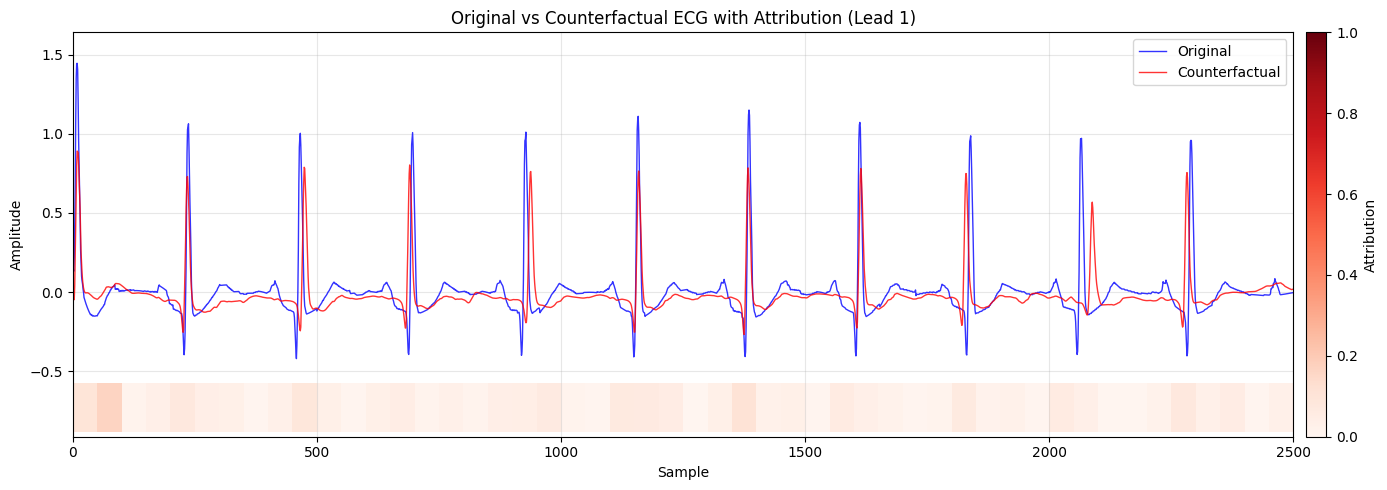

In [104]:
# Visualize counterfactual with attribution
from execg.visualizer import plot_counterfactual_diff_with_attribution

plot_counterfactual_diff_with_attribution(
    original_ecg_np,
    cf_ecg,
    attribution=attribution_result["results"],
    lead_idx=1,
    bin_size=50,
    cmap="Reds",
)

In [102]:
from execg.visualizer import plot_ecg_chart, plot_ecg_comparison
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


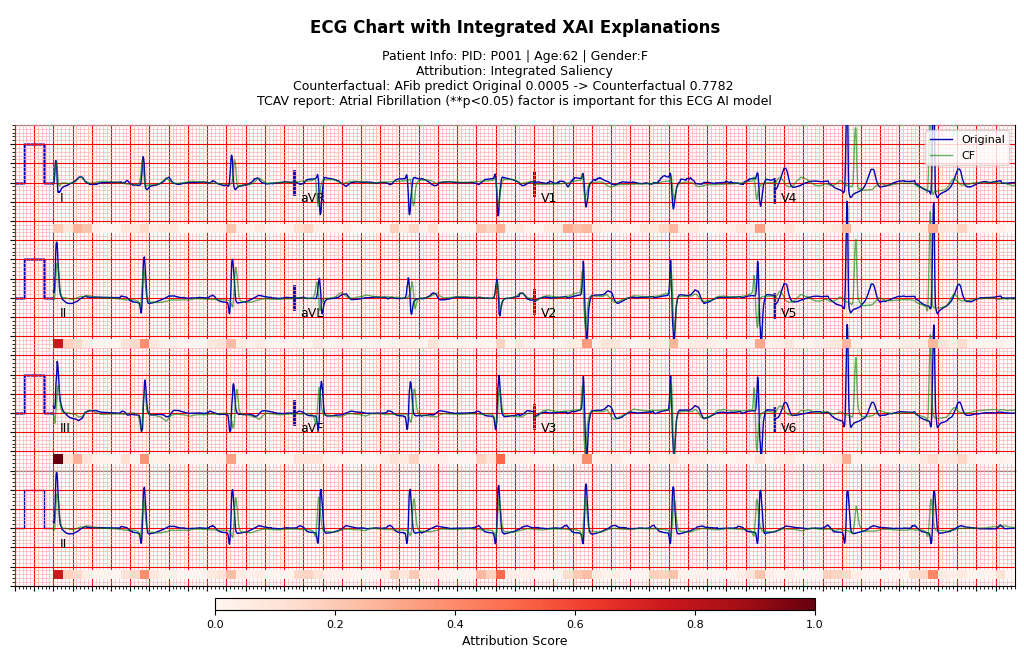

In [107]:
# Full XAI visualization
meta_full = {
    "Patient Info": "PID: P001 | Age:62 | Gender:F",
    "Attribution": "Integrated Saliency",
    "Counterfactual":"AFib predict Original 0.0005 -> Counterfactual 0.7782 ",
    "TCAV report": "Atrial Fibrillation (**p<0.05) factor is important for this ECG AI model",
}

fig, axes = plot_ecg_chart(
    original_ecg_np,
    sample_rate=250,
    cf_ecg=cf_ecg,
    ecg_linewidth=1,
    attribution=attribution_result['results'],
    meta=meta_full,
    title="ECG Chart with Integrated XAI Explanations",
    cf_color="green",
    cf_alpha=0.6,
    attr_bin_size=25,
    attr_cmap="Reds",
    style="clinical",
    columns=4,
    show_full_single_last=True,
    show_calibration=True,
    save_path='../tmp/paper/figures/ECGchart.png'
)

In [ ]:
# You can also use GradCAM for attribution
from execg.attribution import GradCAM

# Find last conv layer
layer_names = wrapped_model.get_layer_names()
conv_layers = [name for name in layer_names if "conv" in name.lower()]
target_layer = conv_layers[-1]

gradcam = GradCAM(
    model=wrapped_model,
    absolute=True,
    normalize=True,
)

gradcam_result = gradcam.explain(
    ecg_tensor,
    target=target,
    target_layers=target_layer,
    method="gradcam",
)

# Visualize with GradCAM attribution
plot_counterfactual_diff_with_attribution(
    original_ecg_np,
    cf_ecg,
    attribution=gradcam_result["results"][0],
    lead_idx=1,
    bin_size=50,
    cmap="Purples",
)